<a href="https://colab.research.google.com/github/Shafiq-Abdu/abdulrahman.github.io/blob/main/Bayesian_Optimisation_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Installing Packages

In [ ]:
!pip install panda
!pip install numpy
!pip install matplotlib
!pip install yfinance
!pip install mplfinance
!pip install bayesian-optimization


  Preparing metadata (setup.py) ... done
  Created wheel for panda: filename=panda-0.3.1-py3-none-any.whl size=7239 sha256=ebc0c56f096233e26a88b9afe76c606b82c5308962a868b76919c9258d73b530
  Stored in directory: /root/.cache/pip/wheels/0e/8b/c3/ff9cbde1fffd8071cff8367a86f0350a1ce30a8d31b6a432e9
Successfully built panda
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 1.2 MB/s eta 0:00:00


In [ ]:
pip install scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.7/107.7 kB 1.3 MB/s eta 0:00:00


In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from bayes_opt import BayesianOptimization

## Strategy definition

In [ ]:
def fetch_asset_data(symbol, start_date, end_date):
    # Fetch OHLCV data using yfinance
    asset_data = yf.download(symbol, start=start_date, end=end_date)
    # Convert the data to a DataFrame
    df = pd.DataFrame(asset_data)
    # Drop any rows with missing values
    df.dropna(inplace=True)
    return df


In [ ]:

def supertrend(df, atr_period=15, atr_multiplier=3):
    # Calculate the Upper Band(UB) and the Lower Band(LB)
    # Formula: Supertrend = (High + Low) / 2 + (Multiplier) * (ATR)
    current_average_high_low = (df['High'] + df['Low']) / 2

    # Calculate True Range (TR)
    df['tr1'] = df['High'] - df['Low']
    df['tr2'] = abs(df['High'] - df['Close'].shift())
    df['tr3'] = abs(df['Low'] - df['Close'].shift())
    df['tr'] = df[['tr1', 'tr2', 'tr3']].max(axis=1)

    # Calculate ATR
    df['atr'] = df['tr'].rolling(window=atr_period).mean()

    # Drop temporary columns
    df.drop(['tr1', 'tr2', 'tr3', 'tr'], axis=1, inplace=True)

    df.dropna(inplace=True)
    df['basicUpperband'] = current_average_high_low + (atr_multiplier * df['atr'])
    df['basicLowerband'] = current_average_high_low - (atr_multiplier * df['atr'])
    first_upperBand_value = df['basicUpperband'].iloc[0]
    first_lowerBand_value = df['basicLowerband'].iloc[0]
    upperBand = [first_upperBand_value]
    lowerBand = [first_lowerBand_value]

    for i in range(1, len(df)):
        if df['basicUpperband'].iloc[i] < upperBand[i-1] or df['Close'].iloc[i-1] > upperBand[i-1]:
            upperBand.append(df['basicUpperband'].iloc[i])
        else:
            upperBand.append(upperBand[i-1])

        if df['basicLowerband'].iloc[i] > lowerBand[i-1] or df['Close'].iloc[i-1] < lowerBand[i-1]:
            lowerBand.append(df['basicLowerband'].iloc[i])
        else:
            lowerBand.append(lowerBand[i-1])

    df['upperband'] = upperBand
    df['lowerband'] = lowerBand
    df.drop(['basicUpperband', 'basicLowerband'], axis=1, inplace=True)

    return df
 #   Generate signals
def generate_signals(df):
    # Initialize a signals list
    signals = []

    # Loop through the dataframe
    for i in range(len(df)):
        if df['Close'][i] > df['upperband'][i]:
            signals.append(1)  # Buy signal
        elif df['Close'][i] < df['lowerband'][i]:
            signals.append(-1)  # Sell signal
        else:
            signals.append(0)  # No signal

    # Add the signals list as a new column in the dataframe
    df['signals'] = signals
    df['signals'] = df['signals'].shift(1)  # Remove look-ahead bias
    return df

def strategy_performance(strategy_df, capital=100, leverage=1):
    # Initialize the performance variables
    cumulative_balance = capital
    investment = capital
    pl = 0
    max_drawdown = 0
    max_drawdown_percentage = 0
    max_profit = 0  # Initialize max_profit variable

    # Lists to store intermediate values for calculating metrics
    balance_list = [capital]
    pnl_list = [0]
    investment_list = [capital]
    peak_balance = capital
    drawdown_list = [0]  # List to store maximum drawdown at each iteration
    profit_list = [0]  # List to store profit at each iteration

    # Loop from the second row (index 1) of the DataFrame
    for index in range(1, len(strategy_df)):
        row = strategy_df.iloc[index]

        # Calculate P/L as a percentage of investment
        if row['signals'] == 1:
            pl = ((row['Close'] - row['Open']) / row['Open']) * leverage
        elif row['signals'] == -1:
            pl = ((row['Open'] - row['Close']) / row['Close']) * leverage
        else:
            pl = 0

        # Update the investment if there is a signal reversal
        if row['signals'] != strategy_df.iloc[index - 1]['signals']:
            investment = cumulative_balance

        # Calculate the new balance based on P/L
        cumulative_balance += (pl * investment)

        # Update the investment list
        investment_list.append(investment)

        # Calculate the cumulative balance and add it to the DataFrame
        balance_list.append(cumulative_balance)

        # Calculate the overall P/L and add it to the DataFrame
        pnl_list.append(pl)

        # Calculate max drawdown
        drawdown = cumulative_balance - peak_balance
        if drawdown < max_drawdown:
            max_drawdown = drawdown
            max_drawdown_percentage = (max_drawdown / peak_balance) * 100

        # Update the peak balance
        if cumulative_balance > peak_balance:
            peak_balance = cumulative_balance

        # Calculate profit
        profit = cumulative_balance - capital
        if profit > max_profit:
            max_profit = profit

        # Store the maximum drawdown at this iteration
        drawdown_list.append(max_drawdown)
        profit_list.append(profit)

    # Add new columns to the DataFrame
    strategy_df['investment'] = investment_list
    strategy_df['cumulative_balance'] = balance_list
    strategy_df['pl'] = pnl_list
    strategy_df['cumPL'] = strategy_df['pl'].cumsum()
    strategy_df['Max Drawdown'] = drawdown_list  # Add the maximum drawdown column
    strategy_df['Profit'] = profit_list  # Add the profit column

    # Calculate other performance metrics
    overall_pl_percentage = (cumulative_balance - capital) * 100 / capital
    overall_pl = cumulative_balance - capital
    min_balance = min(balance_list)
    max_balance = max(balance_list)
    total_trades = len(strategy_df[strategy_df['signals'] != 0])
    performance_metrics = pd.DataFrame({
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Max Drawdown %', 'Total Trades', 'Max Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", f"{max_drawdown_percentage:.2f}%", total_trades, f"{max_profit:.2f}"]
    })


    # Print the performance metrics
    # print("Overall P/L: {:.2f}%".format(overall_pl_percentage))
    # print("Overall P/L: {:.2f}".format(overall_pl))
    # print("Min balance: {:.2f}".format(min_balance))
    # print("Max balance: {:.2f}".format(max_balance))
    # print("Maximum Drawdown: {:.2f}".format(max_drawdown))
    # print("Maximum Drawdown %: {:.2f}%".format(max_drawdown_percentage))
    # print("Total Trades: {}".format(total_trades))
    # print("Max Profit: {:.2f}".format(max_profit))  # Print max profit
    # print(performance_metrics)
    # Return the Strategy DataFrame
    return strategy_df



In [ ]:
import pandas as pd
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

data=fetch_asset_data(symbol='^NSEI', start_date='2022-01-01', end_date='2024-03-31')

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")


[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 20, ATR Multiplier: 4.377062994324071
Maximum Profit Achieved: 6.031251161537341


In [ ]:
data=fetch_asset_data(symbol='INFY', start_date='2022-01-01', end_date='2024-03-31')

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 14, ATR Multiplier: 4.828620635812186
Maximum Profit Achieved: 8.599942900525093


In [ ]:
data=fetch_asset_data(symbol='HINDUNILVR.NS', start_date='2022-01-01', end_date='2024-03-31')

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 5, ATR Multiplier: 1.0006491500963186
Maximum Profit Achieved: 14.886356622808322


In [ ]:
data=fetch_asset_data(symbol='MSFT', start_date='2022-01-01', end_date='2024-03-31')

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 19, ATR Multiplier: 2.527878236284778
Maximum Profit Achieved: 26.720555887830812


In [ ]:
data=fetch_asset_data(symbol='NVDA', start_date='2022-01-01', end_date='2024-03-31')

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 15, ATR Multiplier: 4.3443150541495115
Maximum Profit Achieved: 22.70560536576528


Heat map generation

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize

[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 14, ATR Multiplier: 4.828620635812186
Maximum Profit Achieved: 8.599942900525093


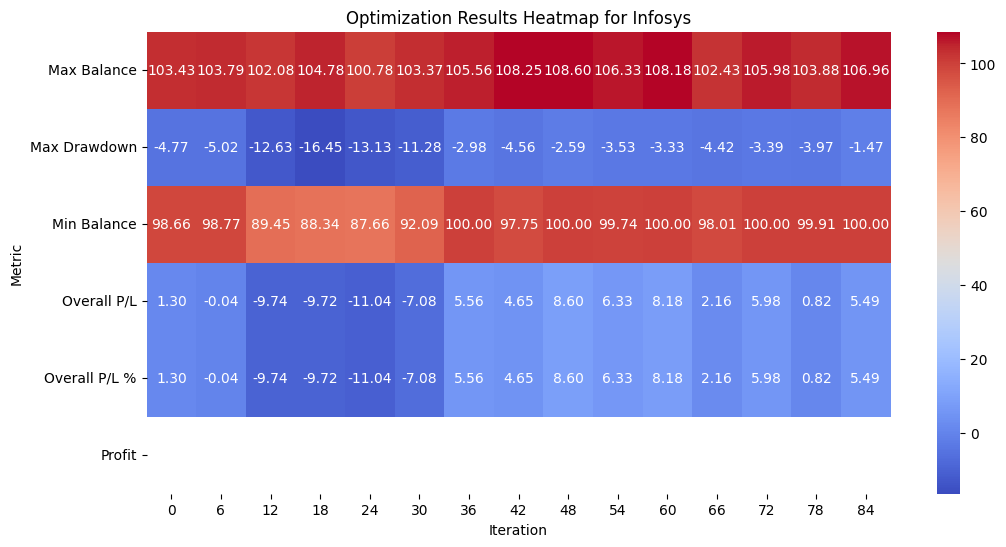

In [ ]:
data = fetch_asset_data(symbol='INFY', start_date='2022-01-01', end_date='2024-03-31')

# Initialize an empty DataFrame to store performance metrics
results_df = pd.DataFrame(columns=['Iteration', 'Metric', 'Value'])

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    global results_df  # Declare results_df as a global variable

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

# # Save the results DataFrame to a CSV file
# results_df.to_csv('results.csv'+symbol, index=False)

results_df['Value'] = results_df['Value'].str.replace('%', '').astype(float)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Metric', columns='Iteration', values='Value')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Optimization Results Heatmap for Infosys')
plt.show()


[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 15, ATR Multiplier: 4.3443150541495115
Maximum Profit Achieved: 22.70560536576528


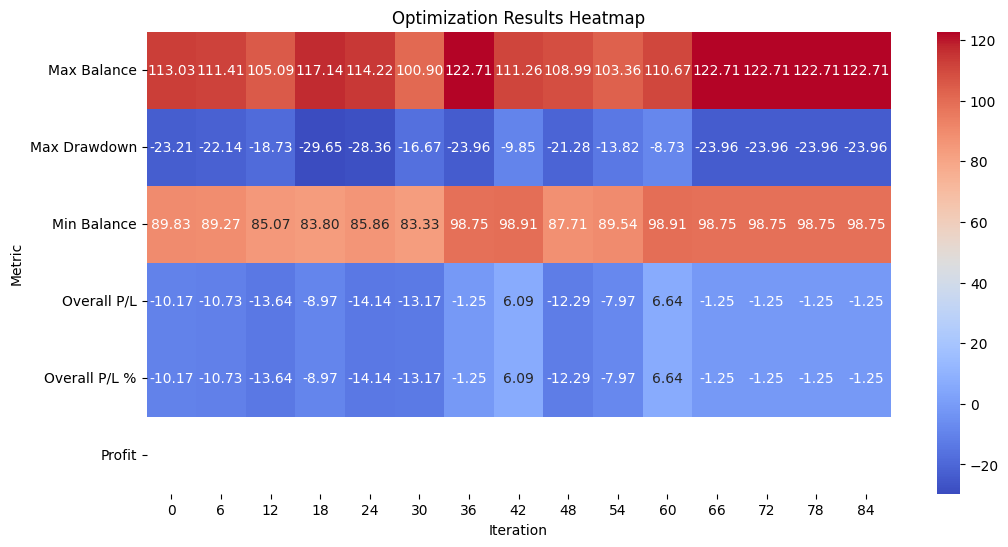

In [ ]:
data = fetch_asset_data(symbol='NVDA', start_date='2022-01-01', end_date='2024-03-31')

# Initialize an empty DataFrame to store performance metrics
results_df = pd.DataFrame(columns=['Iteration', 'Metric', 'Value'])

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    global results_df  # Declare results_df as a global variable

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

# Save the results DataFrame to a CSV file
# results_df.to_csv('results.csv', index=False)

results_df['Value'] = results_df['Value'].str.replace('%', '').astype(float)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Metric', columns='Iteration', values='Value')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Optimization Results Heatmap')
plt.show()


[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 15, ATR Multiplier: 4.3443150541495115
Maximum Profit Achieved: 22.70560536576528


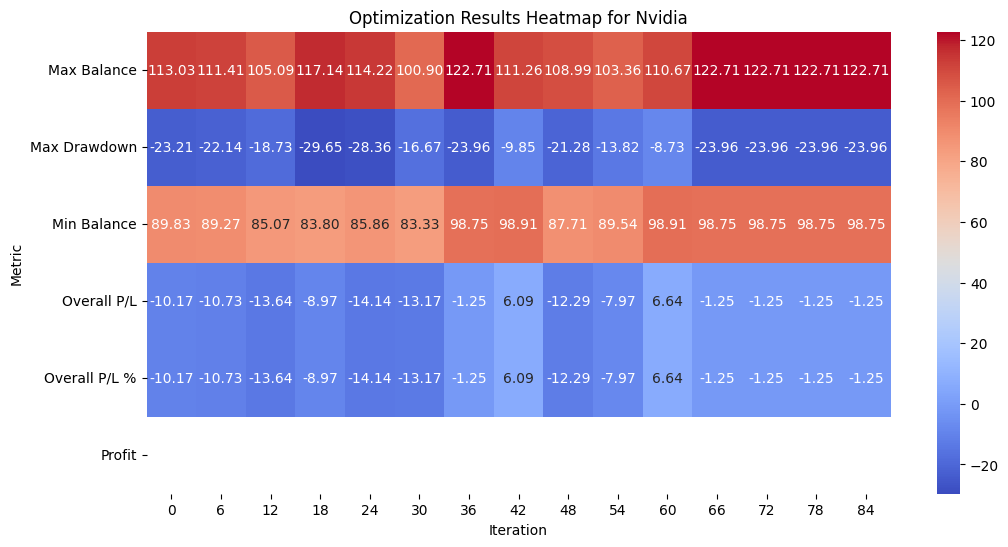

In [ ]:
data = fetch_asset_data(symbol='NVDA', start_date='2022-01-01', end_date='2024-03-31')

# Initialize an empty DataFrame to store performance metrics
results_df = pd.DataFrame(columns=['Iteration', 'Metric', 'Value'])

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    global results_df  # Declare results_df as a global variable

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

# Save the results DataFrame to a CSV file
# results_df.to_csv('results.csv', index=False)

results_df['Value'] = results_df['Value'].str.replace('%', '').astype(float)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Metric', columns='Iteration', values='Value')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Optimization Results Heatmap for Nvidia')
plt.show()


[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 19, ATR Multiplier: 2.527878236284778
Maximum Profit Achieved: 26.720555887830812


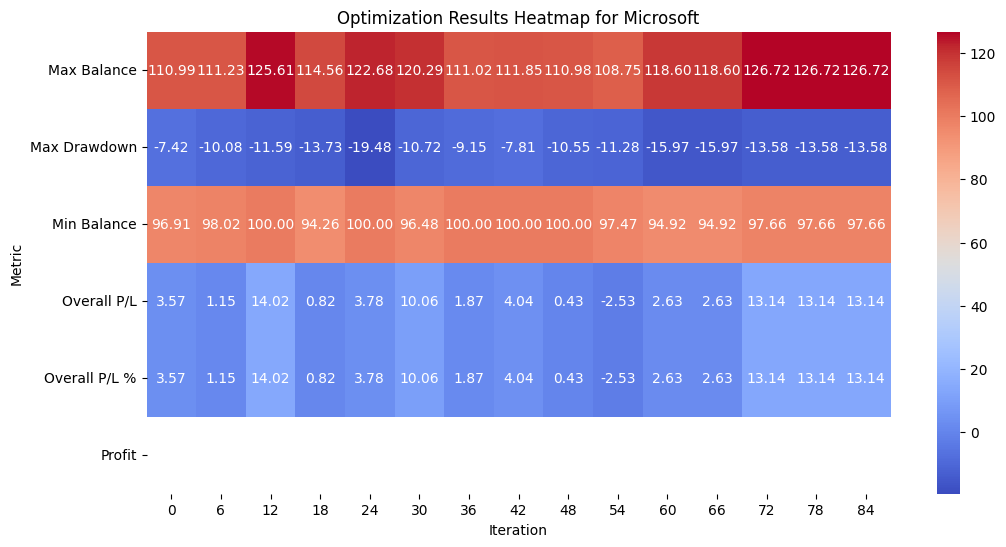

In [ ]:
data = fetch_asset_data(symbol='MSFT', start_date='2022-01-01', end_date='2024-03-31')

# Initialize an empty DataFrame to store performance metrics
results_df = pd.DataFrame(columns=['Iteration', 'Metric', 'Value'])

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    global results_df  # Declare results_df as a global variable

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

# Save the results DataFrame to a CSV file
# results_df.to_csv('results.csv', index=False)

results_df['Value'] = results_df['Value'].str.replace('%', '').astype(float)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Metric', columns='Iteration', values='Value')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Optimization Results Heatmap for Microsoft')
plt.show()


[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 20, ATR Multiplier: 4.377062994324071
Maximum Profit Achieved: 6.031251161537341


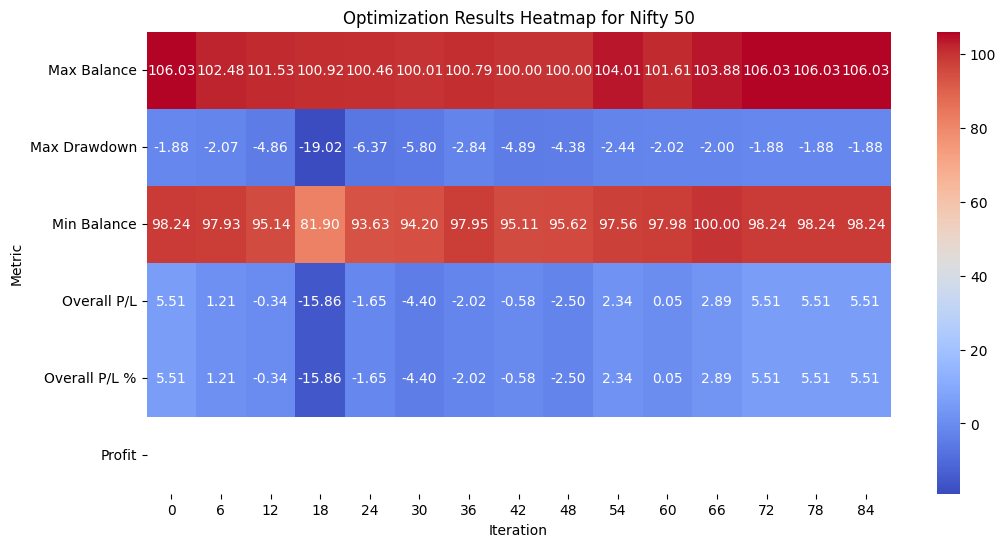

In [ ]:
data = fetch_asset_data(symbol='^NSEI', start_date='2022-01-01', end_date='2024-03-31')

# Initialize an empty DataFrame to store performance metrics
results_df = pd.DataFrame(columns=['Iteration', 'Metric', 'Value'])

# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    global results_df  # Declare results_df as a global variable

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

# Save the results DataFrame to a CSV file
# results_df.to_csv('results.csv', index=False)

results_df['Value'] = results_df['Value'].str.replace('%', '').astype(float)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Metric', columns='Iteration', values='Value')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Optimization Results Heatmap for Nifty 50')
plt.show()


[*********************100%%**********************]  1 of 1 completed


Best Parameters: 
ATR Period: 5, ATR Multiplier: 1.0006491500963186
Maximum Profit Achieved: 14.886356622808322


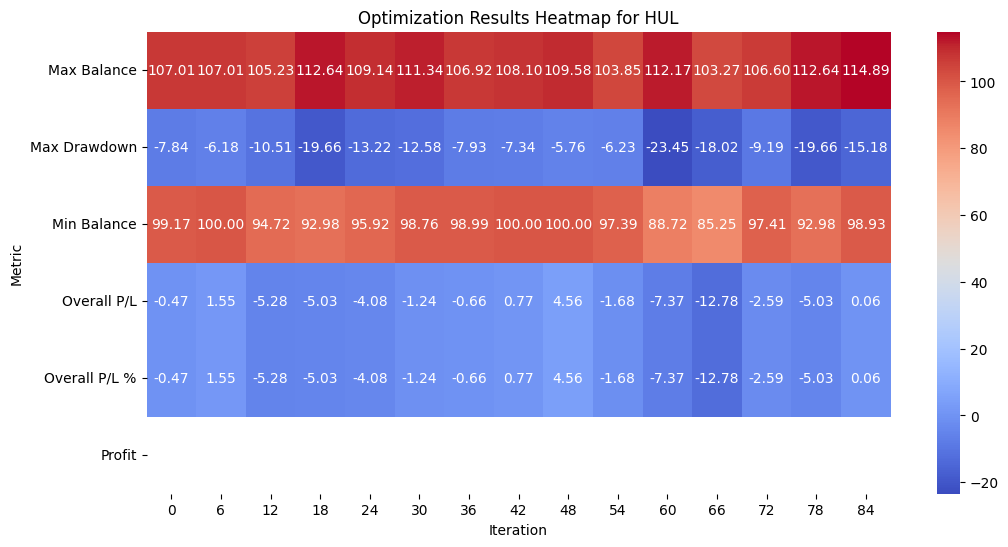

In [ ]:
data = fetch_asset_data(symbol='HINDUNILVR.NS', start_date='2022-01-01', end_date='2024-03-31')

# Initialize an empty DataFrame to store performance metrics
results_df = pd.DataFrame(columns=['Iteration', 'Metric', 'Value'])
# Define the parameter space for optimization
param_space = [
    Integer(5, 30, name='atr_period'),
    Real(1, 5, name='atr_multiplier')
]

# Define the objective function for optimization
@use_named_args(param_space)
def objective(atr_period, atr_multiplier):
    global results_df  # Declare results_df as a global variable

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Perform Bayesian Optimization
res_gp = gp_minimize(objective, param_space, n_calls=15, random_state=0)

# Results
print("Best Parameters: ")
print(f"ATR Period: {res_gp.x[0]}, ATR Multiplier: {res_gp.x[1]}")
print(f"Maximum Profit Achieved: {-res_gp.fun}")

# Save the results DataFrame to a CSV file
# results_df.to_csv('results.csv', index=False)

results_df['Value'] = results_df['Value'].str.replace('%', '').astype(float)

# Create a pivot table for the heatmap
heatmap_data = results_df.pivot(index='Metric', columns='Iteration', values='Value')

# Plot the heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(heatmap_data, cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Optimization Results Heatmap for HUL')
plt.show()


## Bayesian package

In [ ]:
from bayes_opt import BayesianOptimization
# Perform Bayesian Optimization
import plotly.graph_objects as go
from plotly.subplots import make_subplots

[*********************100%%**********************]  1 of 1 completed


|   iter    |  target   | atr_mu... | atr_pe... |
-------------------------------------------------
| 1         | -1.144    | 2.668     | 23.01     |
| 2         | -0.9236   | 1.0       | 12.56     |
| 3         | -3.031    | 1.587     | 7.308     |
| 4         | -0.0      | 1.745     | 13.64     |
| 5         | -3.678    | 2.587     | 18.47     |
| 6         | -0.0      | 3.39      | 13.16     |
| 7         | -0.0      | 2.74      | 27.13     |
| 8         | -0.3795   | 5.0       | 28.99     |
| 9         | -0.7364   | 1.257     | 29.99     |
| 10        | -0.0      | 5.0       | 25.72     |
| 11        | -0.7595   | 1.0       | 25.6      |
| 12        | -0.0      | 5.0       | 10.89     |
| 13        | -0.5899   | 5.0       | 14.42     |
| 14        | -2.484    | 5.0       | 5.0       |
| 15        | -0.5031   | 5.0       | 23.49     |
| 16        | -0.0      | 4.986     | 12.26     |
| 17        | -0.0      | 3.423     | 25.43     |
| 18        | -2.127    | 4.311     | 27.17     |


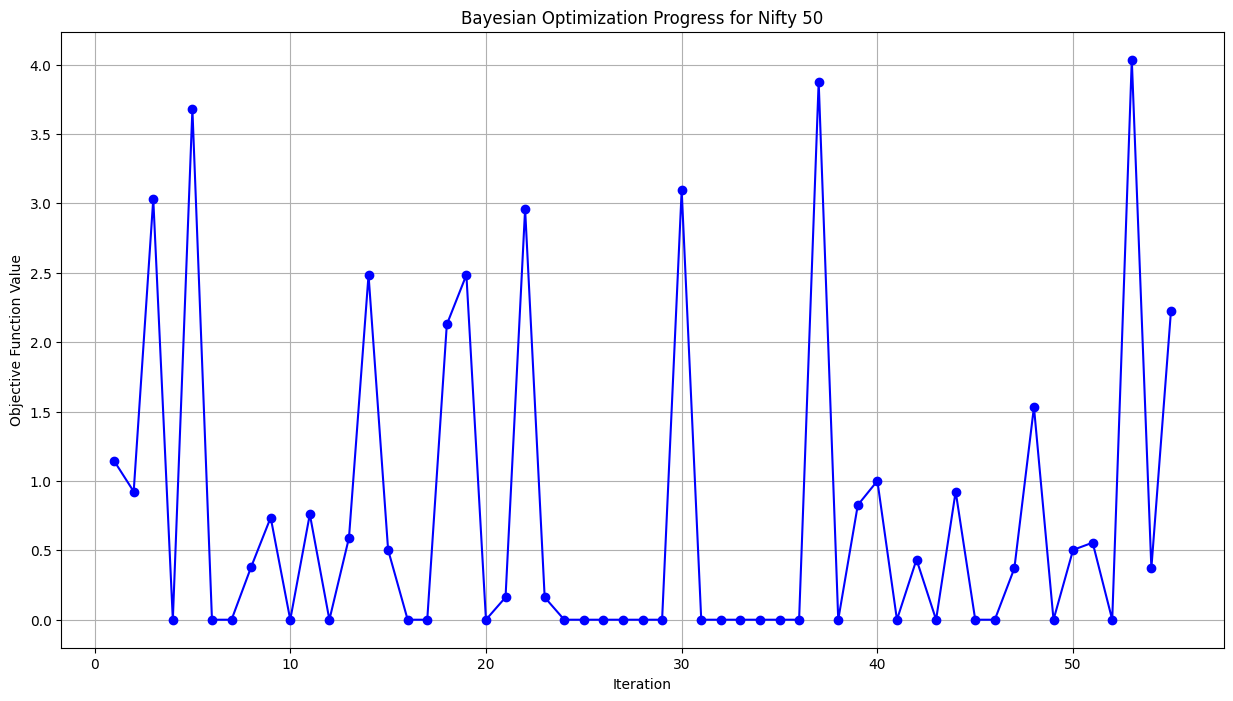

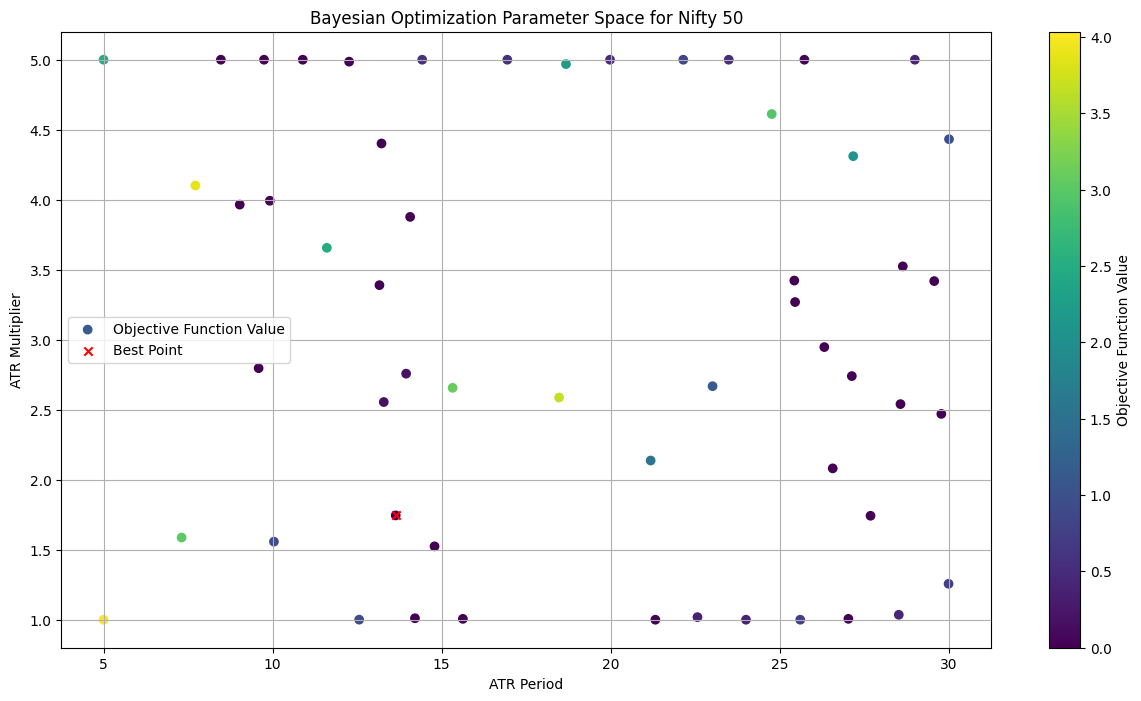

{'target': -0.0, 'params': {'atr_multiplier': 1.7450408455106836, 'atr_period': 13.639018176076194}}


In [ ]:
data = fetch_asset_data(symbol='^NSEI', start_date='2022-01-01', end_date='2024-03-31')

# Define the objective function for optimization
def objective(atr_period, atr_multiplier):
    global data  # Use the global variable 'data' for the asset data
    global results_df  # Use the global variable 'results_df' to store performance metrics

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Bounded region of parameter space
pbounds = {'atr_period': (5, 30), 'atr_multiplier': (1, 5)}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)


# Perform Bayesian Optimization
optimizer.maximize(
    init_points=5,
    n_iter=50,
)


# Extract the iteration number and objective function value from the optimizer results
iterations = [i for i in range(1, len(optimizer.res)+1)]
objective_values = [-res['target'] for res in optimizer.res]

# Plot the objective function value against the iteration number
plt.figure(figsize=(15, 8))
plt.plot(iterations, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Bayesian Optimization Progress for Nifty 50')
plt.grid(True)
plt.show()



# Extract the parameter values and objective function values from the optimizer results
params = [(res['params']['atr_period'], res['params']['atr_multiplier']) for res in optimizer.res]
objective_values = [-res['target'] for res in optimizer.res]

# Extract the best parameter values and objective function value
best_params = optimizer.max['params']
best_objective_value = -optimizer.max['target']

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter([p[0] for p in params], [p[1] for p in params], c=objective_values, cmap='viridis', label='Objective Function Value')
plt.colorbar(label='Objective Function Value')
plt.scatter(best_params['atr_period'], best_params['atr_multiplier'], marker='x', color='red', label='Best Point')
plt.xlabel('ATR Period')
plt.ylabel('ATR Multiplier')
plt.title('Bayesian Optimization Parameter Space for Nifty 50')
plt.legend()
plt.grid(True)
plt.show()



# Print the best parameters and maximum profit achieved
print(optimizer.max)


[*********************100%%**********************]  1 of 1 completed

|   iter    |  target   | atr_mu... | atr_pe... |
-------------------------------------------------


| 1         | -18.87    | 2.668     | 23.01     |
| 2         | -14.56    | 1.0       | 12.56     |
| 3         | -19.66    | 1.587     | 7.308     |
| 4         | -14.55    | 1.745     | 13.64     |
| 5         | -20.71    | 2.587     | 18.47     |
| 6         | -11.7     | 4.336     | 12.14     |
| 7         | -0.0      | 5.0       | 10.06     |
| 8         | -0.0      | 5.0       | 8.806     |
| 9         | -0.8126   | 5.0       | 30.0      |
| 10        | -14.95    | 1.76      | 30.0      |
| 11        | -0.0      | 5.0       | 27.71     |
| 12        | -0.0      | 5.0       | 5.0       |
| 13        | -0.0      | 5.0       | 6.645     |
| 14        | -0.0      | 5.0       | 25.66     |
| 15        | -13.34    | 3.46      | 26.59     |
| 16        | -0.0      | 5.0       | 23.76     |
| 17        | -0.0      | 5.0       | 21.54     |
| 18        | -0.0      | 5.0       | 19.77     |
| 19        | -0.0      | 5.0       | 16.79     |
| 20        | -1.317    | 5.0       | 15.16     |


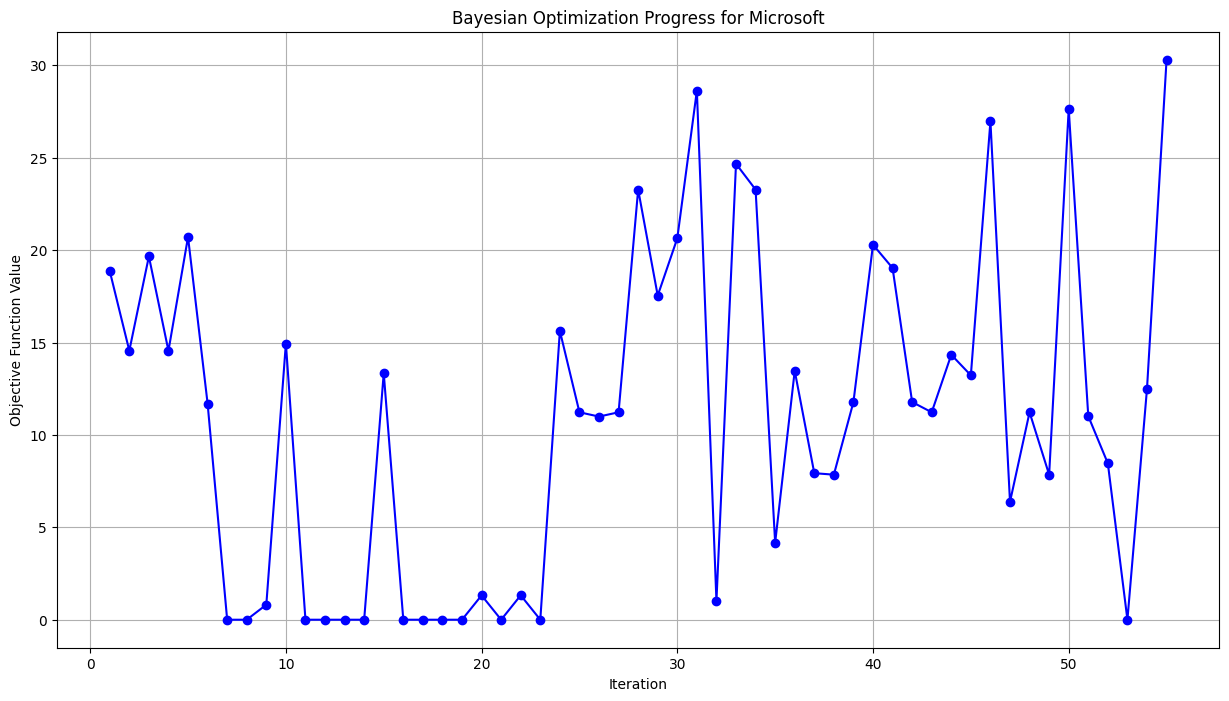

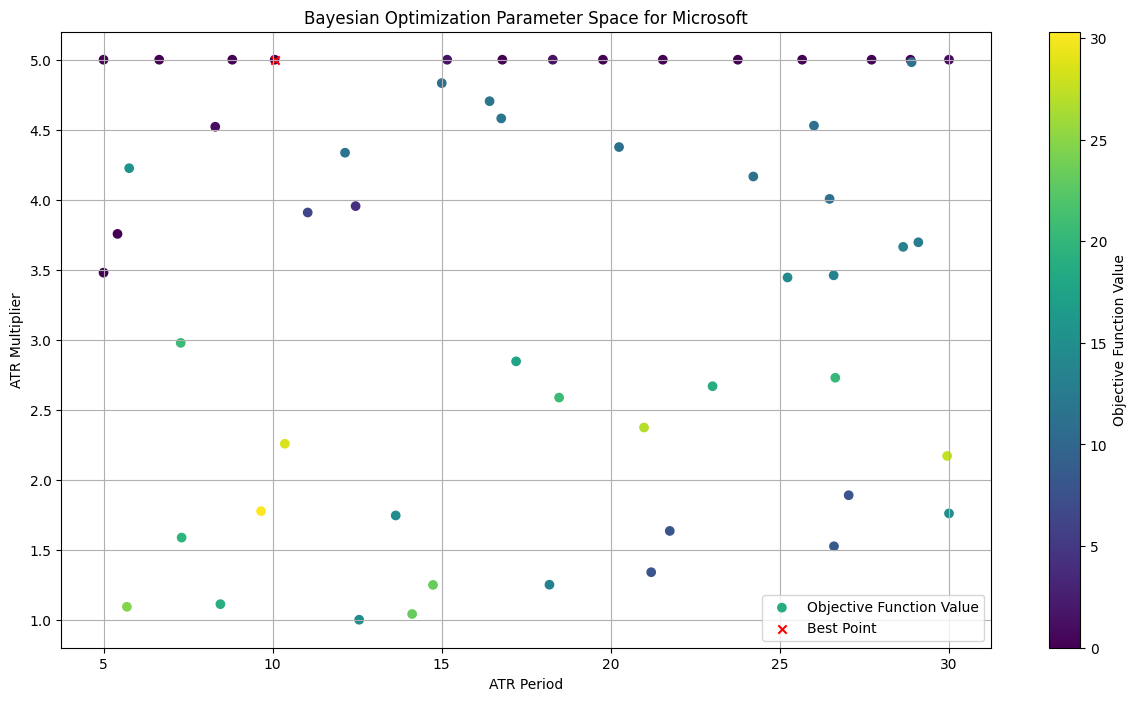

{'target': -0.0, 'params': {'atr_multiplier': 5.0, 'atr_period': 10.061465467548205}}


In [ ]:
data = fetch_asset_data(symbol='MSFT', start_date='2022-01-01', end_date='2024-03-31')

# Define the objective function for optimization
def objective(atr_period, atr_multiplier):
    global data  # Use the global variable 'data' for the asset data
    global results_df  # Use the global variable 'results_df' to store performance metrics

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Bounded region of parameter space
pbounds = {'atr_period': (5, 30), 'atr_multiplier': (1, 5)}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)


# Perform Bayesian Optimization
optimizer.maximize(
    init_points=5,
    n_iter=50,
)


# Extract the iteration number and objective function value from the optimizer results
iterations = [i for i in range(1, len(optimizer.res)+1)]
objective_values = [-res['target'] for res in optimizer.res]

# Plot the objective function value against the iteration number
plt.figure(figsize=(15, 8))
plt.plot(iterations, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Bayesian Optimization Progress for Microsoft')
plt.grid(True)
plt.show()



# Extract the parameter values and objective function values from the optimizer results
params = [(res['params']['atr_period'], res['params']['atr_multiplier']) for res in optimizer.res]
objective_values = [-res['target'] for res in optimizer.res]

# Extract the best parameter values and objective function value
best_params = optimizer.max['params']
best_objective_value = -optimizer.max['target']

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter([p[0] for p in params], [p[1] for p in params], c=objective_values, cmap='viridis', label='Objective Function Value')
plt.colorbar(label='Objective Function Value')
plt.scatter(best_params['atr_period'], best_params['atr_multiplier'], marker='x', color='red', label='Best Point')
plt.xlabel('ATR Period')
plt.ylabel('ATR Multiplier')
plt.title('Bayesian Optimization Parameter Space for Microsoft')
plt.legend()
plt.grid(True)
plt.show()



# Print the best parameters and maximum profit achieved
print(optimizer.max)


[*********************100%%**********************]  1 of 1 completed

|   iter    |  target   | atr_mu... | atr_pe... |
-------------------------------------------------


| 1         | -0.0      | 2.668     | 23.01     |
| 2         | -17.14    | 1.0       | 12.56     |
| 3         | -6.779    | 1.587     | 7.308     |
| 4         | -5.269    | 1.745     | 13.64     |
| 5         | -0.0      | 2.587     | 18.47     |
| 6         | -16.07    | 1.435     | 14.22     |
| 7         | -0.0      | 2.567     | 18.49     |
| 8         | -12.08    | 3.026     | 19.09     |
| 9         | -1.617    | 2.307     | 17.97     |
| 10        | -0.0      | 2.663     | 23.67     |
| 11        | -6.038    | 3.384     | 23.35     |
| 12        | -0.0      | 2.024     | 23.34     |
| 13        | -28.34    | 1.984     | 24.24     |
| 14        | -0.0      | 2.031     | 22.72     |
| 15        | -13.1     | 1.594     | 15.17     |
| 16        | -14.28    | 1.276     | 22.86     |
| 17        | -0.0      | 2.473     | 22.14     |
| 18        | -7.15     | 3.214     | 22.13     |
| 19        | -0.0      | 2.025     | 23.31     |
| 20        | -13.37    | 1.921     | 21.66     |


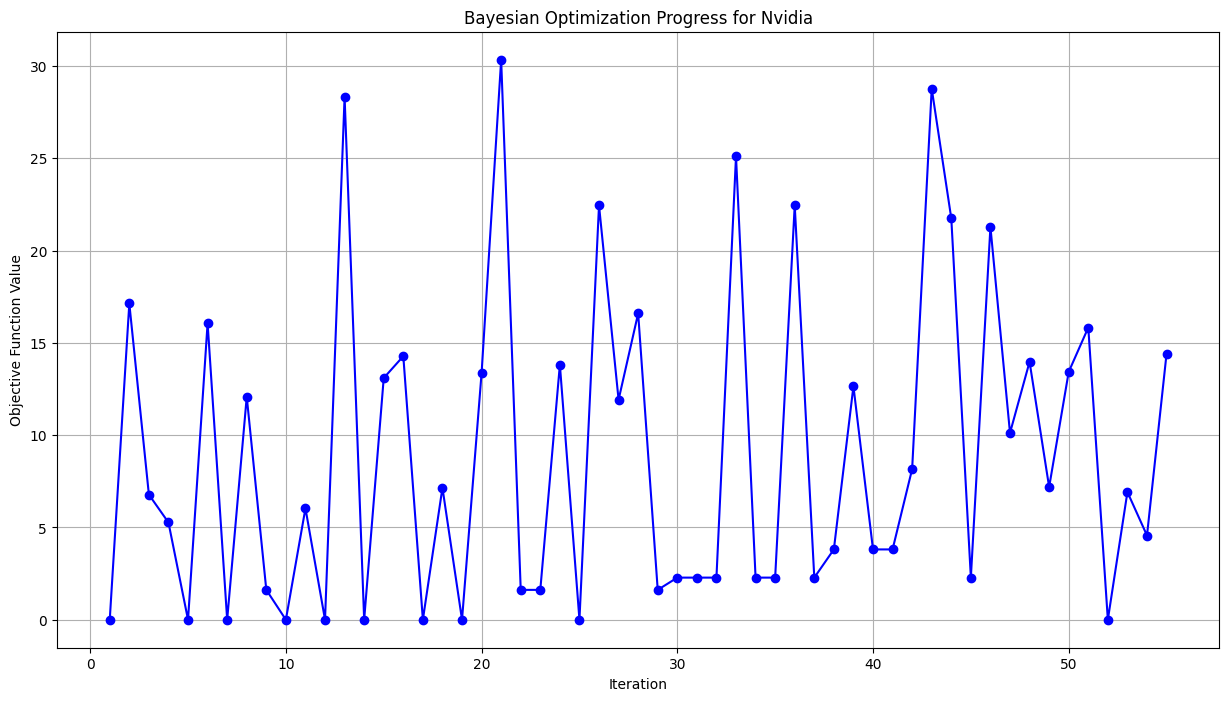

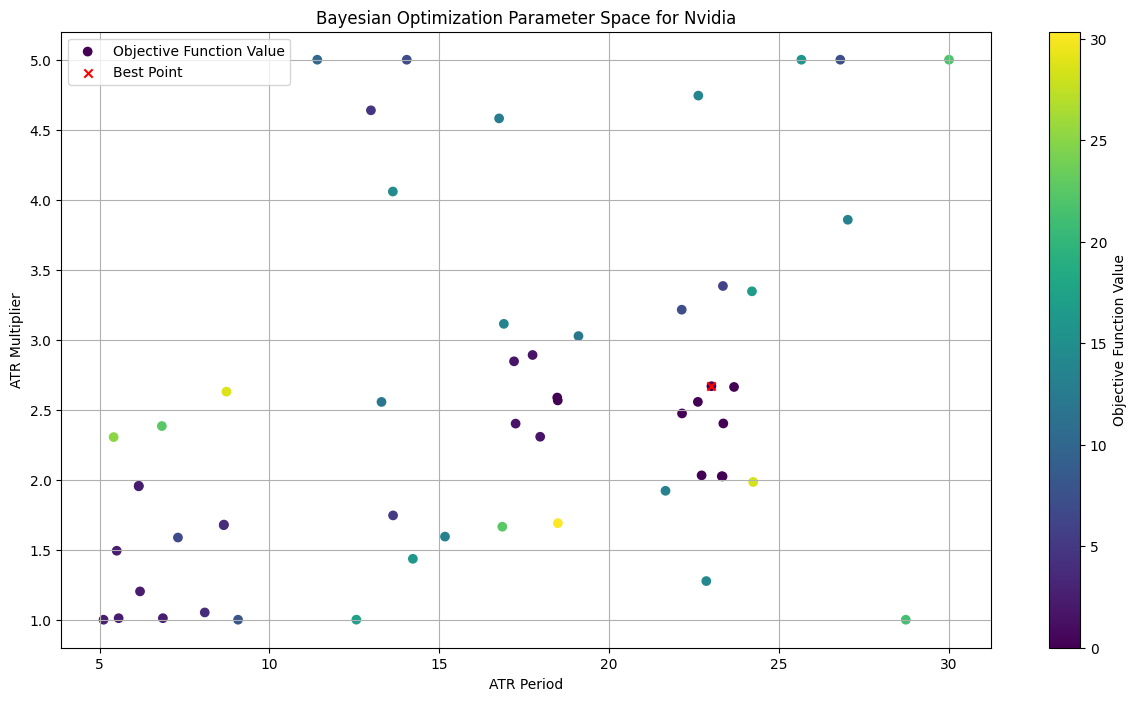

{'target': -0.0, 'params': {'atr_multiplier': 2.668088018810296, 'atr_period': 23.00811233605395}}


In [ ]:
data = fetch_asset_data(symbol='NVDA', start_date='2022-01-01', end_date='2024-03-31')

# Define the objective function for optimization
def objective(atr_period, atr_multiplier):
    global data  # Use the global variable 'data' for the asset data
    global results_df  # Use the global variable 'results_df' to store performance metrics

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Bounded region of parameter space
pbounds = {'atr_period': (5, 30), 'atr_multiplier': (1, 5)}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)


# Perform Bayesian Optimization
optimizer.maximize(
    init_points=5,
    n_iter=50,
)


# Extract the iteration number and objective function value from the optimizer results
iterations = [i for i in range(1, len(optimizer.res)+1)]
objective_values = [-res['target'] for res in optimizer.res]

# Plot the objective function value against the iteration number
plt.figure(figsize=(15, 8))
plt.plot(iterations, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Bayesian Optimization Progress for Nvidia')
plt.grid(True)
plt.show()



# Extract the parameter values and objective function values from the optimizer results
params = [(res['params']['atr_period'], res['params']['atr_multiplier']) for res in optimizer.res]
objective_values = [-res['target'] for res in optimizer.res]

# Extract the best parameter values and objective function value
best_params = optimizer.max['params']
best_objective_value = -optimizer.max['target']

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter([p[0] for p in params], [p[1] for p in params], c=objective_values, cmap='viridis', label='Objective Function Value')
plt.colorbar(label='Objective Function Value')
plt.scatter(best_params['atr_period'], best_params['atr_multiplier'], marker='x', color='red', label='Best Point')
plt.xlabel('ATR Period')
plt.ylabel('ATR Multiplier')
plt.title('Bayesian Optimization Parameter Space for Nvidia')
plt.legend()
plt.grid(True)
plt.show()



# Print the best parameters and maximum profit achieved
print(optimizer.max)


[*********************100%%**********************]  1 of 1 completed

|   iter    |  target   | atr_mu... | atr_pe... |
-------------------------------------------------


| 1         | -8.717    | 2.668     | 23.01     |
| 2         | -12.64    | 1.0       | 12.56     |
| 3         | -13.31    | 1.587     | 7.308     |
| 4         | -3.271    | 1.745     | 13.64     |
| 5         | -6.123    | 2.587     | 18.47     |
| 6         | -11.81    | 1.435     | 14.22     |
| 7         | -7.892    | 4.32      | 21.5      |
| 8         | -12.17    | 1.597     | 20.72     |
| 9         | -8.088    | 1.344     | 23.97     |
| 10        | -12.68    | 2.583     | 9.036     |
| 11        | -6.916    | 4.551     | 16.18     |
| 12        | -8.37     | 2.729     | 13.8      |
| 13        | -8.292    | 3.44      | 14.82     |
| 14        | -6.703    | 3.213     | 22.55     |
| 15        | -12.52    | 1.594     | 15.17     |
| 16        | -12.17    | 1.267     | 18.36     |
| 17        | -3.304    | 2.357     | 11.87     |
| 18        | -12.17    | 1.764     | 21.84     |
| 19        | -6.916    | 4.639     | 15.4      |
| 20        | -8.088    | 1.672     | 22.1      |


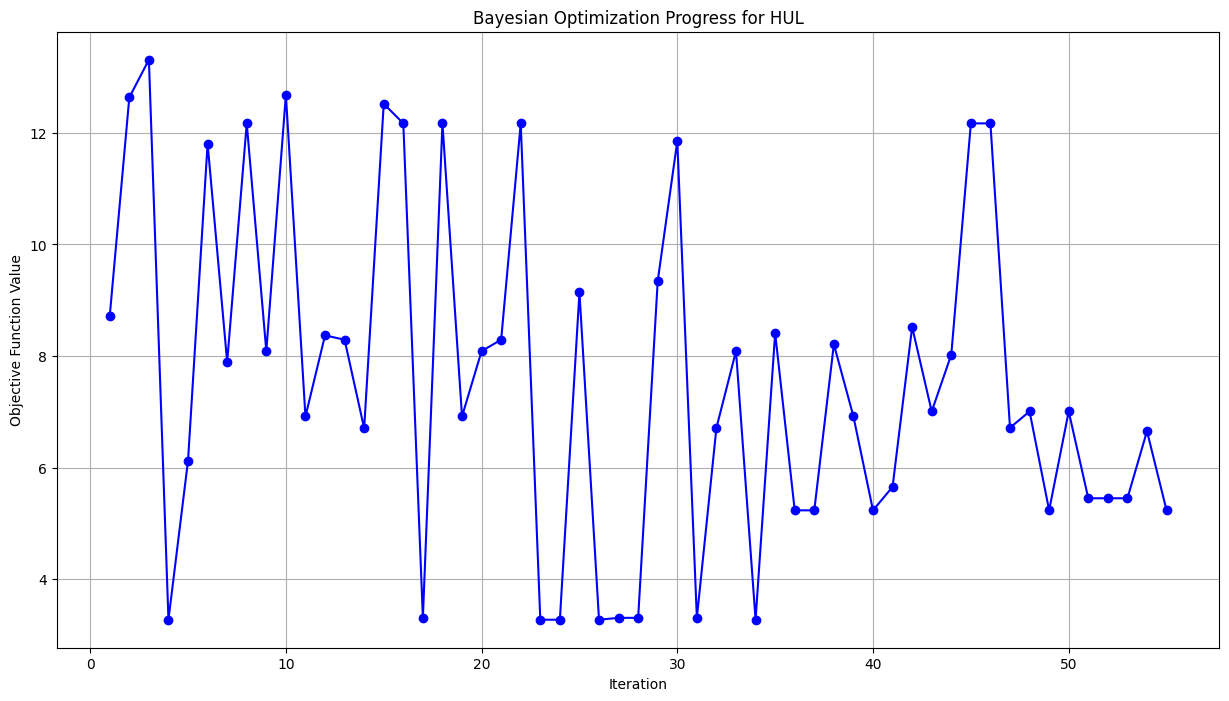

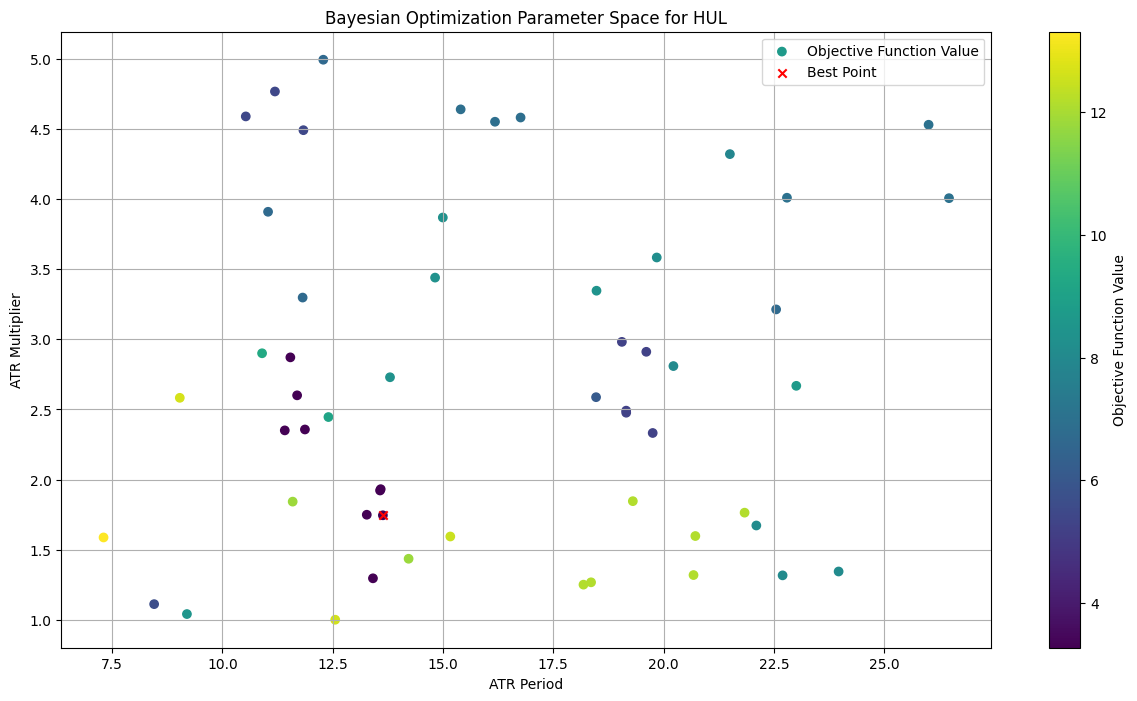

{'target': -3.270797328705825, 'params': {'atr_multiplier': 1.7450408455106836, 'atr_period': 13.639018176076194}}


In [ ]:
data = fetch_asset_data(symbol='HINDUNILVR.NS', start_date='2022-01-01', end_date='2024-03-31')

# Define the objective function for optimization
def objective(atr_period, atr_multiplier):
    global data  # Use the global variable 'data' for the asset data
    global results_df  # Use the global variable 'results_df' to store performance metrics

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Bounded region of parameter space
pbounds = {'atr_period': (5, 30), 'atr_multiplier': (1, 5)}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)


# Perform Bayesian Optimization
optimizer.maximize(
    init_points=5,
    n_iter=50,
)


# Extract the iteration number and objective function value from the optimizer results
iterations = [i for i in range(1, len(optimizer.res)+1)]
objective_values = [-res['target'] for res in optimizer.res]

# Plot the objective function value against the iteration number
plt.figure(figsize=(15, 8))
plt.plot(iterations, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Bayesian Optimization Progress for HUL')
plt.grid(True)
plt.show()



# Extract the parameter values and objective function values from the optimizer results
params = [(res['params']['atr_period'], res['params']['atr_multiplier']) for res in optimizer.res]
objective_values = [-res['target'] for res in optimizer.res]

# Extract the best parameter values and objective function value
best_params = optimizer.max['params']
best_objective_value = -optimizer.max['target']

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter([p[0] for p in params], [p[1] for p in params], c=objective_values, cmap='viridis', label='Objective Function Value')
plt.colorbar(label='Objective Function Value')
plt.scatter(best_params['atr_period'], best_params['atr_multiplier'], marker='x', color='red', label='Best Point')
plt.xlabel('ATR Period')
plt.ylabel('ATR Multiplier')
plt.title('Bayesian Optimization Parameter Space for HUL')
plt.legend()
plt.grid(True)
plt.show()



# Print the best parameters and maximum profit achieved
print(optimizer.max)


[*********************100%%**********************]  1 of 1 completed

|   iter    |  target   | atr_mu... | atr_pe... |
-------------------------------------------------


| 1         | -2.961    | 2.668     | 23.01     |
| 2         | -4.783    | 1.0       | 12.56     |
| 3         | -3.004    | 1.587     | 7.308     |
| 4         | -1.615    | 1.745     | 13.64     |
| 5         | -3.111    | 2.587     | 18.47     |
| 6         | -1.615    | 1.774     | 13.69     |
| 7         | -4.021    | 2.405     | 13.3      |
| 8         | -4.912    | 1.597     | 20.72     |
| 9         | -1.615    | 1.366     | 13.92     |
| 10        | -4.649    | 1.686     | 14.69     |
| 11        | -1.615    | 1.105     | 13.57     |
| 12        | -3.877    | 3.583     | 24.29     |
| 13        | -6.404    | 1.337     | 23.46     |
| 14        | -5.706    | 3.655     | 22.28     |
| 15        | -4.38     | 2.765     | 6.82      |
| 16        | -3.6      | 1.0       | 8.297     |
| 17        | -4.775    | 1.002     | 6.373     |
| 18        | -11.67    | 3.588     | 17.91     |
| 19        | -4.957    | 1.636     | 18.7      |
| 20        | -7.31     | 2.264     | 8.28      |


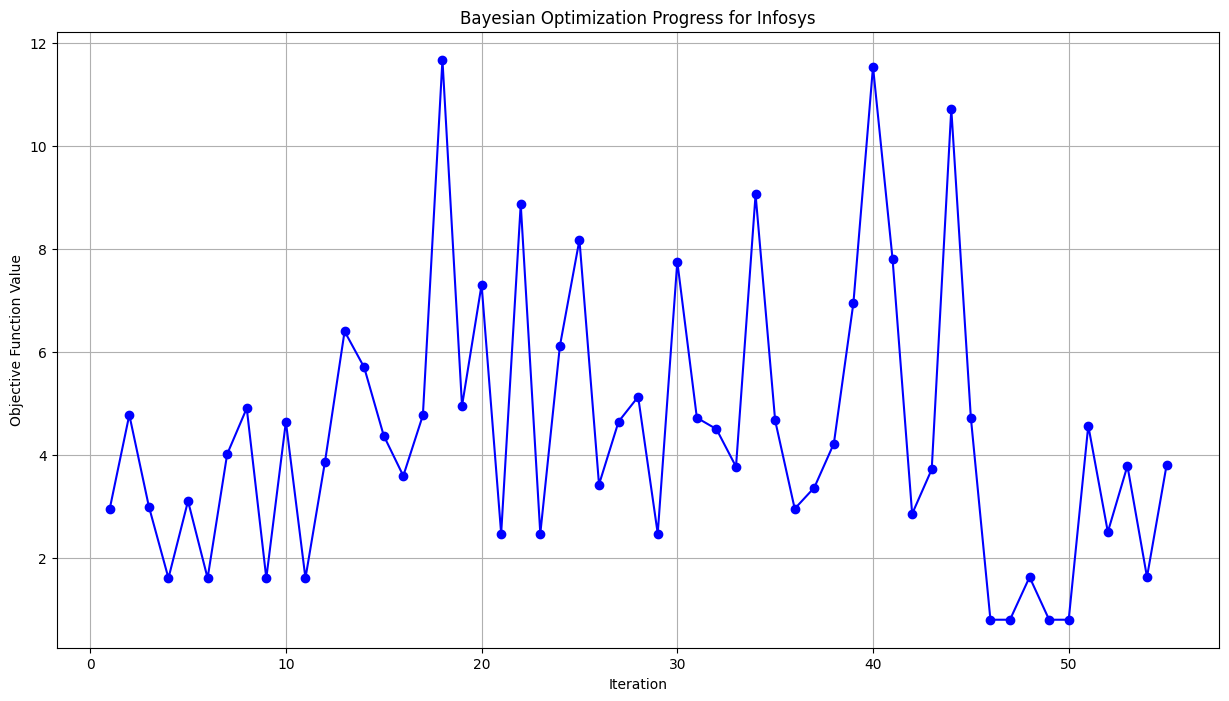

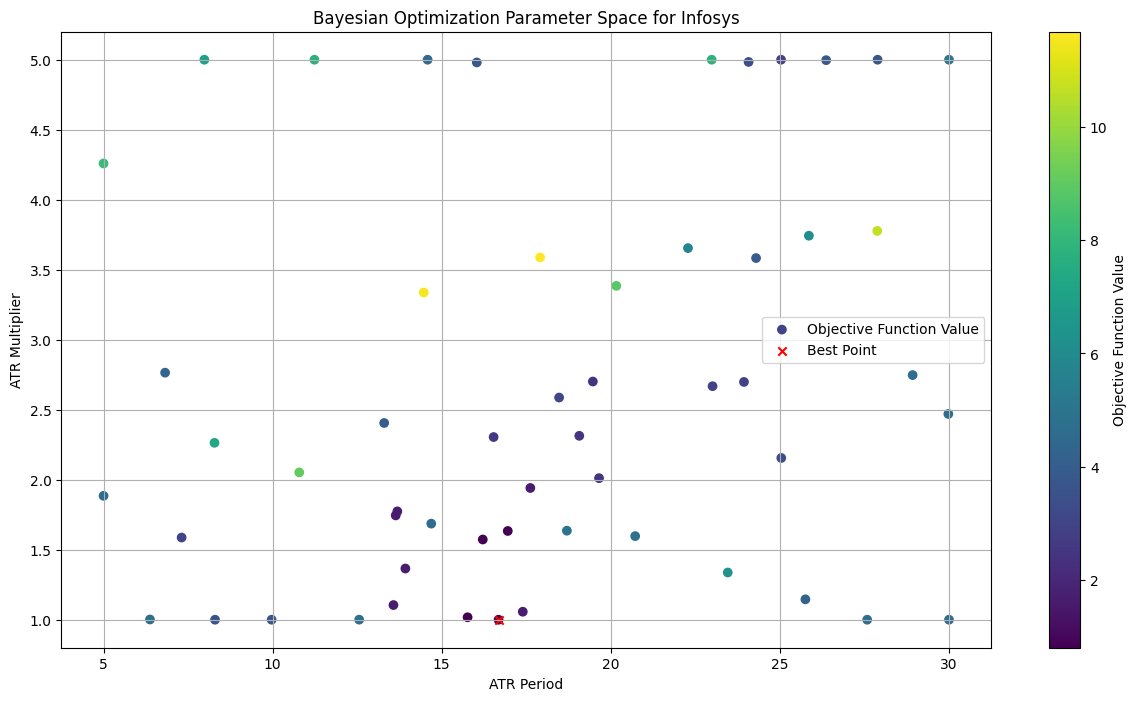

{'target': -0.8080412449894823, 'params': {'atr_multiplier': 1.0, 'atr_period': 16.68072265785582}}


In [ ]:
data = fetch_asset_data(symbol='INFY', start_date='2022-01-01', end_date='2024-03-31')

# Define the objective function for optimization
def objective(atr_period, atr_multiplier):
    global data  # Use the global variable 'data' for the asset data
    global results_df  # Use the global variable 'results_df' to store performance metrics

    # Your supertrend, generate_signals, and strategy_performance functions are used here
    atr_period = int(atr_period)
    atr_multiplier = int(atr_multiplier)

    # Generate the supertrend data with the given parameters
    supertrend_data = supertrend(data.copy(), atr_period=atr_period, atr_multiplier=atr_multiplier)

    # Generate trading signals based on supertrend
    supertrend_positions = generate_signals(supertrend_data)

    # Evaluate the strategy performance
    strategy_df = strategy_performance(supertrend_positions, capital=100, leverage=1)

    # Calculate performance metrics
    overall_pl_percentage = (strategy_df['cumulative_balance'].iloc[-1] - 100) / 100 * 100
    overall_pl = strategy_df['cumulative_balance'].iloc[-1] - 100
    min_balance = strategy_df['cumulative_balance'].min()
    max_balance = strategy_df['cumulative_balance'].max()
    max_drawdown = strategy_df['Max Drawdown'].min()

    # Append the metrics to the results DataFrame
    metrics = {
        'Iteration': len(results_df),
        'Metric': ['Overall P/L %', 'Overall P/L', 'Min Balance', 'Max Balance', 'Max Drawdown', 'Profit'],
        'Value': [f"{overall_pl_percentage:.2f}%", f"{overall_pl:.2f}", f"{min_balance:.2f}", f"{max_balance:.2f}", f"{max_drawdown:.2f}", strategy_df['Profit'].max()]
    }
    results_df = pd.concat([results_df, pd.DataFrame(metrics)], ignore_index=True)

    # Return the negative of the maximum profit for maximization
    return -strategy_df['Profit'].max()

# Bounded region of parameter space
pbounds = {'atr_period': (5, 30), 'atr_multiplier': (1, 5)}

optimizer = BayesianOptimization(
    f=objective,
    pbounds=pbounds,
    random_state=1,
)


# Perform Bayesian Optimization
optimizer.maximize(
    init_points=5,
    n_iter=50,
)


# Extract the iteration number and objective function value from the optimizer results
iterations = [i for i in range(1, len(optimizer.res)+1)]
objective_values = [-res['target'] for res in optimizer.res]

# Plot the objective function value against the iteration number
plt.figure(figsize=(15, 8))
plt.plot(iterations, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Iteration')
plt.ylabel('Objective Function Value')
plt.title('Bayesian Optimization Progress for Infosys')
plt.grid(True)
plt.show()



# Extract the parameter values and objective function values from the optimizer results
params = [(res['params']['atr_period'], res['params']['atr_multiplier']) for res in optimizer.res]
objective_values = [-res['target'] for res in optimizer.res]

# Extract the best parameter values and objective function value
best_params = optimizer.max['params']
best_objective_value = -optimizer.max['target']

# Create a scatter plot
plt.figure(figsize=(15, 8))
plt.scatter([p[0] for p in params], [p[1] for p in params], c=objective_values, cmap='viridis', label='Objective Function Value')
plt.colorbar(label='Objective Function Value')
plt.scatter(best_params['atr_period'], best_params['atr_multiplier'], marker='x', color='red', label='Best Point')
plt.xlabel('ATR Period')
plt.ylabel('ATR Multiplier')
plt.title('Bayesian Optimization Parameter Space for Infosys')
plt.legend()
plt.grid(True)
plt.show()



# Print the best parameters and maximum profit achieved
print(optimizer.max)
